In [7]:
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd
from prettytable import PrettyTable

# 连接到数据库
conn = sqlite3.connect('plan.db')
cursor = conn.cursor()

# 查询所有交易记录
cursor.execute("SELECT * FROM trade")
rows = cursor.fetchall()

# 初始化持仓仓位、总成本和盈亏
position = {}
total_cost = {}
profit_loss = {}

# 遍历每一行交易记录
for row in rows:
    symbol, purpose, side, quality, price, filled_time, planID, note = row
    
    if symbol not in position:
        position[symbol] = 0
        total_cost[symbol] = 0
        profit_loss[symbol] = 0
    
    if purpose == 'open' and side == 'long':
        # 做多，增加仓位和成本
        position[symbol] += quality
        total_cost[symbol] += quality * price
        profit_loss[symbol] -= quality * price
    elif purpose == 'open' and side == 'short':
        # 做空，减少仓位和成本
        position[symbol] -= quality
        total_cost[symbol] -= quality * price
        profit_loss[symbol] += quality * price
    elif purpose == 'close' and side == 'long':
        # 平仓多单，减少仓位和成本
        position[symbol] -= quality
        total_cost[symbol] -= quality * price
        profit_loss[symbol] += quality * price
    elif purpose == 'close' and side == 'short':
        # 平仓空单，增加仓位和成本
        position[symbol] += quality
        total_cost[symbol] += quality * price
        profit_loss[symbol] -= quality * price

# 关闭数据库连接
conn.close()

# 计算每个股票的平均成本
avg_cost = {}
for symbol in position:
    if position[symbol] != 0:
        avg_cost[symbol] = total_cost[symbol] / abs(position[symbol])

# 从 "EMA169" 表中获取 last_price
conn = sqlite3.connect('plan.db')
cursor = conn.cursor()
cursor.execute("SELECT symbol, last_price FROM EMA169")
price_rows = cursor.fetchall()
conn.close()

# 将 last_price 转换为字典
last_price_dict = {symbol: last_price for symbol, last_price in price_rows}

# 计算盈亏百分比和绝对数值
gain_loss = []
total_net_value = 0
total_gain = 0
total_loss = 0

for symbol in avg_cost:
    if symbol in last_price_dict:
        last_price = last_price_dict[symbol]
        avg_cost_price = avg_cost[symbol]
        abs_gain_loss = (last_price - avg_cost_price) * abs(position[symbol])
        pct_gain_loss = (last_price - avg_cost_price) / avg_cost_price * 100
        gain_loss.append([symbol, avg_cost_price, last_price, abs_gain_loss, pct_gain_loss])
        
        total_net_value += last_price * abs(position[symbol])
        if abs_gain_loss > 0:
            total_gain += abs_gain_loss
        else:
            total_loss += abs_gain_loss

# 将盈亏信息转换为DataFrame
df_gain_loss = pd.DataFrame(gain_loss, columns=["Symbol", "Average Cost", "Last Price", "Absolute Gain/Lose", "Percentage Gain/Lose"])

# 按照 "Absolute Gain/Lose" 的绝对值排序
df_gain_loss_sorted = df_gain_loss.reindex(df_gain_loss["Absolute Gain/Lose"].abs().sort_values(ascending=False).index)

# 添加总持仓净值、亏损总和、盈利总和及差值到汇总数据
summary_data = pd.DataFrame([["Total Net Value", total_net_value],
                             ["Total Gain", total_gain],
                             ["Total Loss", total_loss],
                             ["Difference", total_gain + total_loss]], columns=["Metric", "Value"])

# 定义高亮样式
def highlight_gain_loss(val):
    color = 'red' if val < 0 else 'green'
    return f'background-color: {color}'

# 应用高亮样式
styled_gain_loss_table = df_gain_loss_sorted.style.applymap(highlight_gain_loss, subset=['Absolute Gain/Lose', 'Percentage Gain/Lose'])

# 显示盈亏表格
print("Gain/Loss Table (Sorted by Absolute Gain/Lose):")
print(styled_gain_loss_table)

# 显示汇总数据
print("\nSummary Data:")
print(summary_data)

# 如果你想要在 Jupyter Notebook 中显示，可以使用以下代码：
display(styled_gain_loss_table)
# display(summary_data)

C:\Users\Rhino\AppData\Local\Temp\ipykernel_22632\884033450.py:106: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_gain_loss_table = df_gain_loss_sorted.style.applymap(highlight_gain_loss, subset=['Absolute Gain/Lose', 'Percentage Gain/Lose'])


Gain/Loss Table (Sorted by Absolute Gain/Lose):

Summary Data:
            Metric     Value
0  Total Net Value  43731.85
1       Total Gain   2652.80
2       Total Loss  -1385.08
3       Difference   1267.72


,Symbol,Average Cost,Last Price,Absolute Gain/Lose,Percentage Gain/Lose
3,AMD,128.100000,114.170000,-696.500000,-10.874317
20,BABA,74.460000,135.970000,615.100000,82.608112
12,UBER,43.200000,81.260000,380.600000,88.101852
2,MRK,100.310000,87.680000,-378.900000,-12.590968
15,PAAS,22.220000,25.500000,328.000000,14.761476
8,LRCX,73.900000,89.020000,302.400000,20.460081
14,NEM,39.810000,48.090000,248.400000,20.798794
6,BKR,37.870000,46.910000,180.800000,23.871138
4,NVDA,123.000000,140.110000,171.100000,13.910569
16,NGD,2.708000,3.010000,151.000000,11.152142


Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: prettytable in c:\users\rhino\appdata\local\programs\python\python312\lib\site-packages (3.14.0)




[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\Rhino\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
UPS: 持仓已结算，盈亏为 -102.00
HAS: 持仓已结算，盈亏为 70.00



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\Rhino\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip
C:\Users\Rhino\AppData\Local\Temp\ipykernel_22632\692124027.py:76: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_table = df_closed.style.applymap(highlight_gain_loss, subset=['Gain/Lose'])


,Symbol,Gain/Lose
0,UPS,-102.000000
1,HAS,70.000000


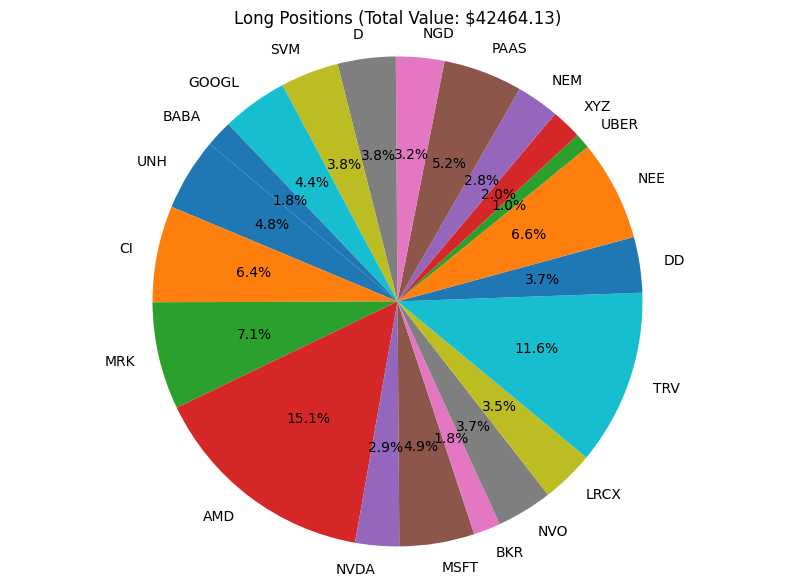

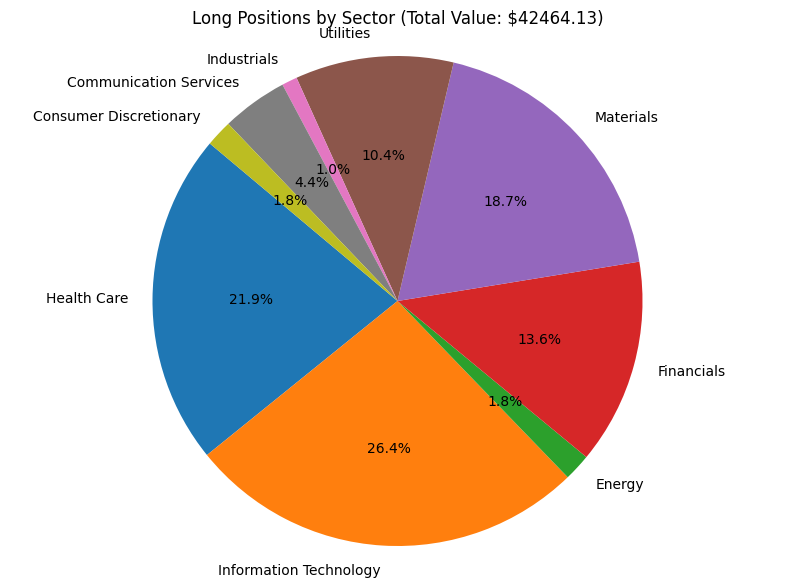

In [8]:
%pip install prettytable
%pip install prettytable
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd
from prettytable import PrettyTable
import csv

# 数据库路径
db_path = "plan.db"
# CSV 文件路径
csv_path = "watch 2025-02-11.csv"  # 替换为你的 CSV 文件路径

# 连接到数据库
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# 查询所有交易记录
cursor.execute("SELECT * FROM trade")
rows = cursor.fetchall()

# 初始化持仓仓位和盈亏
position = {}
position_value = {}
profit_loss = {}

# 遍历每一行交易记录
for row in rows:
    symbol, purpose, side, quality, price, filled_time, planID, note = row
    
    if symbol not in position:
        position[symbol] = 0
        position_value[symbol] = 0
        profit_loss[symbol] = 0
    
    if purpose == 'open' and side == 'long':
        # 做多，增加仓位
        position[symbol] += quality
        position_value[symbol] += quality * price
        profit_loss[symbol] -= quality * price
    elif purpose == 'open' and side == 'short':
        # 做空，减少仓位
        position[symbol] -= quality
        position_value[symbol] -= quality * price
        profit_loss[symbol] += quality * price
    elif purpose == 'close' and side == 'long':
        # 平仓多单，减少仓位
        position[symbol] -= quality
        position_value[symbol] -= quality * price
        profit_loss[symbol] += quality * price
    elif purpose == 'close' and side == 'short':
        # 平仓空单，增加仓位
        position[symbol] += quality
        position_value[symbol] += quality * price
        profit_loss[symbol] -= quality * price

# 关闭数据库连接
conn.close()

# 输出最终的持仓仓位和盈亏
closed_positions = []
for symbol in position:
    if position[symbol] == 0:
        closed_positions.append([symbol, profit_loss[symbol]])
        print(f"{symbol}: 持仓已结算，盈亏为 {profit_loss[symbol]:.2f}")

# 将已结算的盈亏转为DataFrame
df_closed = pd.DataFrame(closed_positions, columns=["Symbol", "Gain/Lose"])

# 定义高亮样式
def highlight_gain_loss(val):
    color = 'red' if val < 0 else 'green'
    return f'background-color: {color}'

# 应用高亮样式
styled_table = df_closed.style.applymap(highlight_gain_loss, subset=['Gain/Lose'])
display(styled_table)

# 计算未结算持仓总价值
total_long_value = sum(value for symbol, value in position_value.items() if position[symbol] > 0)
total_short_value = sum(value for symbol, value in position_value.items() if position[symbol] < 0)

# 绘制未结算的持仓饼状图
long_positions = {symbol: position_value[symbol] for symbol in position if position[symbol] > 0}
short_positions = {symbol: -position_value[symbol] for symbol in position if position[symbol] < 0}

if long_positions:
    plt.figure(figsize=(10, 7))
    plt.pie(long_positions.values(), labels=long_positions.keys(), autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title(f'Long Positions (Total Value: ${total_long_value:.2f})')
    plt.show()

if short_positions:
    plt.figure(figsize=(10, 7))
    plt.pie(short_positions.values(), labels=short_positions.keys(), autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title(f'Short Positions (Total Value: ${total_short_value:.2f})')
    plt.show()

# 从 CSV 文件中读取板块信息
def load_sector_data(csv_path):
    sector_data = {}
    with open(csv_path, mode='r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            symbol = row['Symbol']
            sector = row['Sector']
            sector_data[symbol] = sector
    return sector_data

# 加载板块信息
sector_data = load_sector_data(csv_path)

# 计算每个板块的持仓比例
sector_long_value = {}
sector_short_value = {}

for symbol, value in position_value.items():
    sector = sector_data.get(symbol, "Unknown")  # 如果找不到板块，标记为 "Unknown"
    if position[symbol] > 0:  # 多头仓位
        if sector not in sector_long_value:
            sector_long_value[sector] = 0
        sector_long_value[sector] += value
    elif position[symbol] < 0:  # 空头仓位
        if sector not in sector_short_value:
            sector_short_value[sector] = 0
        sector_short_value[sector] += -value

# 绘制多头板块持仓比例的饼图
if sector_long_value:
    plt.figure(figsize=(10, 7))
    plt.pie(sector_long_value.values(), labels=sector_long_value.keys(), autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title(f'Long Positions by Sector (Total Value: ${total_long_value:.2f})')
    plt.show()

# 绘制空头板块持仓比例的饼图
if sector_short_value:
    plt.figure(figsize=(10, 7))
    plt.pie(sector_short_value.values(), labels=sector_short_value.keys(), autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title(f'Short Positions by Sector (Total Value: ${total_short_value:.2f})')
    plt.show()